In [1]:
import numpy as np
import xarray as xr
from matplotlib import  pyplot as plt
import pandas as pd
import urllib
import cartopy.crs as ccrs
import datetime
from matplotlib import ticker
import os, sys
import pickle
import glob
from scipy.optimize import minimize
from os import path
from datetime import timedelta
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter
import WetBulb
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon

In [2]:
# Generate temperature range (in degrees C)
N_steps = 500

min_temp = 0
max_temp = 50

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0
max_q = 0.035

q = np.linspace(min_q, max_q, N_steps)

# Calculate wet bulb temperature grid
pres = 1000*100 # set general surface pressure to 1000 hPa

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
pres_grid = np.ones_like(temp_grid)*pres

Twb,Teq,epott = WetBulb.WetBulb(temp_grid, pres_grid, q_grid, HumidityMode = 0)

/home/ivanov/jupyternb/Stickiness/to_upload/WetBulb.py:288: RuntimeWarning: divide by zero encountered in log
  tl = (1.0/((1.0/((T1 - 55))) - (np.log(relhum/100.0)/2840.0))) + 55.0


# Derivation using wet bulb temperature (Tw)

## Computational

In [ ]:
def stick_TW(v):
    
    # Calculate stick using input vector
    C_00 = v[0]
    C_10 = v[1]
    C_01 = v[2]
    C_11 = v[3]
    C_20 = v[4]
    C_02 = v[5]
    C_21 = v[6]
    C_12 = v[7]
    C_22 = v[8]
    C_30 = v[9]
    C_03 = v[10]
    C_31 = v[11]
    C_13 = v[12]
    C_32 = v[13]
    C_23 = v[14]
    C_33 = v[15]

    spice = (C_00 + C_10*q_grid + C_01*temp_grid + C_11*q_grid*temp_grid + 
             C_20*q_grid**2 + C_02*temp_grid**2 + C_21*(q_grid**2)*temp_grid + 
             C_12*(temp_grid**2)*q_grid + C_22*(q_grid**2)*(temp_grid**2) + 
             C_30*q_grid**3 + C_03*temp_grid**3 + C_31*(q_grid**3)*temp_grid + 
             C_13*(temp_grid**3)*q_grid + C_32*(q_grid**3)*(temp_grid**2) + 
             C_23*(temp_grid**3)*(q_grid**2) + C_33*(q_grid**3)*(temp_grid**3))
    
    lam1 = 0.8
    lam2 = 1 - lam1
    
    dspice_dT, dspice_dq = np.gradient(spice)
    dTW_dT, dTW_dq = np.gradient(Twb)
    
    int1 = (dspice_dq / dTW_dq + dspice_dT/dTW_dT)**2
    int2 = (dspice_dq/dTW_dq - 1)**2
    
    dq = (max_q - min_q)/N_steps
    dT = (max_temp - min_temp)/N_steps
    
    eps = (lam1*np.sum(int1)*dq*dT + lam2*np.sum(int2)*dq*dT)**0.5
    
    print(eps)
    
    return eps

In [ ]:
# Initial guess to start the minimization process
guess = [3.92578019e+00, -7.81268471e+02,  2.36368404e-01, -5.09311865e-01,
         7.02523267e+03,  2.23047656e-03, -2.44331804e+01, -7.54293880e-02,
         4.54184507e-01, -4.15274027e+02, -2.98769414e-05, -2.16736557e+01, 
         1.44044908e-03, -1.17047276e+01, -2.15204251e-02,  3.09008029e-01]
result = minimize(stick_TW,guess, method='nelder-mead', options = {'xatol': 1e-08,'disp': True, 'maxfev': 100000})
print('The final array that minimizes mean squared error is:'+ str(result.x))

# Derivation using surface moist static energy (MSE)

## Analytical

In [3]:
Cp = 1.005  # in units kJ/kg
Lv = 2260   #in units kJ/kg

MSE = Cp * temp_grid + Lv*q_grid

stick_analytic = Cp * temp_grid - Lv*q_grid;

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  


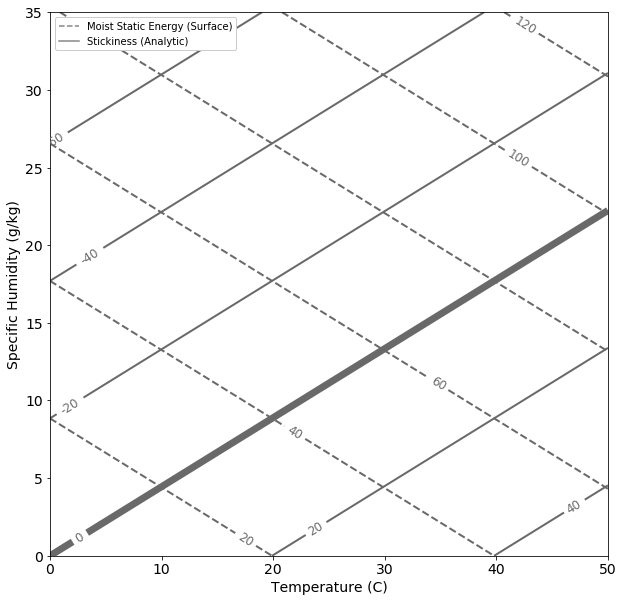

In [4]:
# Plot contours
fig, axs = plt.subplots(1,1,figsize=(10,10))
MSE_cont = axs.contour(temp, 1000*q, MSE, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2, fontweight = 'bold', label = 'MSE')
axs.clabel(MSE_cont, inline=1, fontsize=12, fmt = '%1d')

stick_cont = axs.contour(temp, 1000*q, stick_analytic, colors=('dimgrey',),linestyles = 'solid', zorder = 2, linewidths = 2, fontweight = 'bold', label = 'Stick (Analytic)')
axs.clabel(stick_cont, inline=1, fontsize=12, fmt = '%1d')

axs.set_xlabel('Temperature (C)', fontsize = 14)
axs.set_ylabel('Specific Humidity (g/kg)', fontsize = 14)

line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
labels = ['Moist Static Energy (Surface)', 'Stickiness (Analytic)']

axs.legend([line1, line2],labels, loc = 'upper left', framealpha=1)

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

## Computational

In [7]:
def stick_MSE(x):
    
    # Generate temperature range (in degrees C)
    N_steps = 500

    min_temp = 15
    max_temp = 50

    temp = np.linspace(min_temp,max_temp,N_steps)

    # Generate specific humidity range (in kg/kg)
    min_q = 0
    max_q = 0.035

    q = np.linspace(min_q, max_q, N_steps)
    
    # Calculate wet bulb temperature grid
    pres = 1000*100 # set surface pressure to 1000 hPa

    # Make gridded arrays
    temp_grid, q_grid = np.meshgrid(temp, q) 
    pres_grid = np.ones_like(temp_grid)*pres

    Cp = 1.005  # in units kJ/kg
    Lv = 2260   #in units kJ/kg
    MSE = Cp * temp_grid + Lv*q_grid
    
    # Calculate stick using input vector
    C_10 = x[0]
    C_01 = x[1]
    
    stick = C_10*q_grid + C_01*temp_grid
    
    lam1 = 0.95
    lam2 = 1 - lam1
    
    dstick_dT, dstick_dq = np.gradient(stick)
    dMSE_dT, dMSE_dq = np.gradient(MSE)
    
    int1 = (dstick_dq / dMSE_dq + dstick_dT/dMSE_dT)**2
    int2 = (dstick_dq/dMSE_dq - 1)**2
    
    dq = (max_q - min_q)/N_steps
    dT = (max_temp - min_temp)/N_steps
    
    eps = (lam1*np.sum(int1)*dq*dT + lam2*np.sum(int2)*dq*dT)**0.5
    
    return eps

In [8]:
guess = np.array([500,100])
result = minimize(stick_MSE,guess, method='nelder-mead', options = {'xatol': 1e-12,'disp': True})
print('The final array that minimizes mean squared error is:'+ str(result.x))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 146
         Function evaluations: 285
The final array that minimizes mean squared error is:[-2.260e+03  1.005e+00]


In [11]:
result = [-2.260e+03, 1.005e+00]

## Check how well computational and analytical results match


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  if __name__ == '__main__':
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  del sys.path[0]


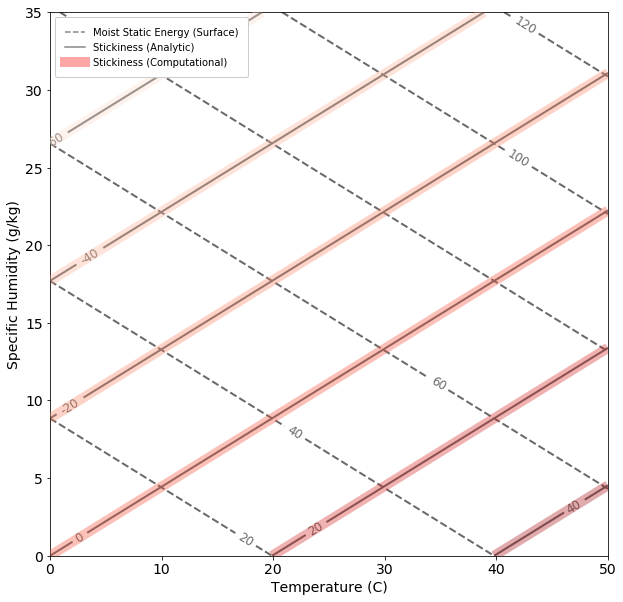

In [12]:
stick_comp = result[1]*temp_grid + result[0]*q_grid;

# Plot contours
fig, axs = plt.subplots(1,1,figsize=(10,10))
MSE_cont = axs.contour(temp, 1000*q, MSE, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2, fontweight = 'bold', label = 'MSE')
axs.clabel(MSE_cont, inline=1, fontsize=12, fmt = '%1d')

# Analytical
stick_cont_anal = axs.contour(temp, 1000*q, stick_analytic, colors=('dimgrey',),linestyles = 'solid', zorder = 2, linewidths = 2, fontweight = 'bold', label = 'Stick (Analytic)')
axs.clabel(stick_cont_anal, inline=1, fontsize=12, fmt = '%1d')

# Computational
stick_cont_comp = plt.contour(temp, 1000*q, stick_comp, cmap = 'Reds', label = 'Stick (Comp.)', linewidths = 10, alpha = 0.35, zorder = 5)

axs.set_xlabel('Temperature (C)', fontsize = 14)
axs.set_ylabel('Specific Humidity (g/kg)', fontsize = 14)

line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
line3 = Line2D([0], [0], color='red', alpha = 0.35, linestyle = 'solid', linewidth = 10)
labels = ['Moist Static Energy (Surface)', 'Stickiness (Analytic)', 'Stickiness (Computational)']

axs.legend([line1, line2,line3],labels, loc = 'upper left', framealpha=1, borderpad=1)

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

# Figure 4

## Load data

In [4]:
# Load single station data
NW_data = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/NWSouthAsia_matcheddates_withdates.csv", index_col = 0, delimiter = '\t')
mw_data = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/Midwest_matcheddates_withdates.csv", index_col = 0, delimiter = '\t')
SEaust_data = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/SEaust_matcheddates_withdates.csv", index_col = 0, delimiter = '\t')
CMElimited_data = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/highTw_CMEstns_matcheddates_withdates.csv", index_col = 0, delimiter = '\t')

In [5]:
col_names = ['stncodes','stnlats','stnlons','stnelevs']
stndata = pd.read_csv('/home/ivanov/matlab/Code/MJO_TW/hadisd_station_metadata_v2019.txt', delimiter = '\s+', header = None, names = col_names)

# Get individual pieces of station data
stncodes = stndata.stncodes.values
stnlats = stndata.stnlats.values
stnlons = stndata.stnlons.values
stnelevs = stndata.stnelevs.values

In [7]:
# Select data for all four regions, mean over all events
NW_means = NW_data.mean()
mw_means = mw_data.mean()
SEaust_means = SEaust_data.mean()
CMElimited_means = CMElimited_data.mean()

In [8]:
# Select data for all four regions, 99th percentile events
NW_ext = NW_data[NW_data['Wet Bulb'] >= NW_data['Wet Bulb'].quantile(0.99)].mean()
mw_ext = mw_data[mw_data['Wet Bulb'] >= mw_data['Wet Bulb'].quantile(0.99)].mean()
SEaust_ext = SEaust_data[SEaust_data['Wet Bulb'] >= SEaust_data['Wet Bulb'].quantile(0.99)].mean()
CMElimited_ext = CMElimited_data[CMElimited_data['Wet Bulb'] >= CMElimited_data['Wet Bulb'].quantile(0.99)].mean()

In [9]:
# Shade area for spatial PDFs

# Load full datasets
TW_allstations = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_TW_allstations.csv", sep='\t')
Tmax_allstations = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_Tmax_allstations.csv", sep='\t')
simulT_allstations = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulT_allstations.csv", sep='\t')
simulSH_allstations = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulSH_allstations.csv", sep='\t')

In [10]:
TW_allstations = TW_allstations.drop(columns = ['Unnamed: 0','Date'])
simulT_allstations = simulT_allstations.drop(columns = ['Unnamed: 0','Date'])
simulSH_allstations = simulSH_allstations.drop(columns = ['Unnamed: 0','Date'])

In [11]:
simulT_means = simulT_allstations.mean()
simulSH_means = simulSH_allstations.mean()

In [12]:
# Load previous data
Z = np.loadtxt("/dx01/ivanov/data/HadISD_stationdata/Spice/KDE_allstations_alltime_biginterval.txt", delimiter=",")

xgrid = np.linspace(-40, 60, 50)
ygrid = np.linspace(0, 40, 50)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

step = 0.0005
levels = np.arange(0.0001,0.01+step,step)

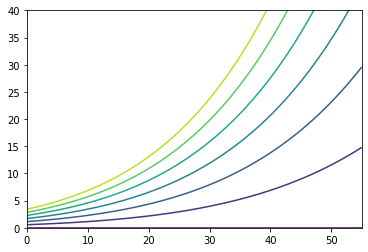

In [8]:
# Make RH contours to add on top
# Generate temperature range (in degrees C)
N_steps = 500

min_temp = 0
max_temp = 55

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0
max_q = 0.04

q = np.linspace(min_q, max_q, N_steps)

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
RH_grid = 0.263*(1000*100)*q_grid*(np.exp((17.67*temp_grid/(temp_grid+273.15-29.65))))**(-1)
RH_grid[RH_grid > 100] = np.nan

RH_cont = plt.contour(temp_grid, 1000*q_grid, RH_grid, vmin = 0, vmax = 100);

In [1]:
# Create colormap for background shading

from matplotlib.colors import LinearSegmentedColormap

large_color = '#882256'

cmap = LinearSegmentedColormap.from_list('mycmap', [ large_color,'white'])

In [10]:
# Using derivation result
result = [1.199557787089589, -7.75269363e+02, 3.02416275e-01, 3.08627625e+00,
              7.74095672e+03, 1.78241619e-03, -2.38012318e+02, -4.98714576e-01,
              2.40170949e+01, 7.18600120e+03, -2.75682633e-05, 4.29814844e+02,
              7.01883383e-03, -2.83672170e+02, -3.67109506e-01, 5.09430371e+00]

stick_TW = -1*(result[0] + result[1]*q_grid + result[2]*temp_grid + result[3]*q_grid*temp_grid + 
             result[4]*q_grid**2 + result[5]*temp_grid**2 + result[6]*(q_grid**2)*temp_grid + 
             result[7]*(temp_grid**2)*q_grid + result[8]*(q_grid**2)*(temp_grid**2) + 
             result[9]*q_grid**3 + result[10]*temp_grid**3 + result[11]*(q_grid**3)*temp_grid + 
             result[12]*(temp_grid**3)*q_grid + result[13]*(q_grid**3)*(temp_grid**2) + 
             result[14]*(temp_grid**3)*(q_grid**2) + result[15]*(q_grid**3)*(temp_grid**3))

In [11]:
# Shade saturated region
from scipy.interpolate import griddata

def grid(x, y, z, resX=1000, resY=1000):
    #prepare to create grid
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    #grid x, y, z
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method='linear')
    return X, Y, Z

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
RH_grid = 0.263*(1000*100)*q_grid*(np.exp((17.67*temp_grid/(temp_grid+273.15-29.65))))**(-1);

pres = 1000*100 # set general surface pressure to 1000 hPa
pres_grid = np.ones_like(temp_grid)*pres

Twb,Teq,epott = WetBulb.WetBulb(temp_grid, pres_grid, q_grid, HumidityMode = 0)

e_s = 6.11*np.exp(((2.5*(10**6))/461.52)*((1/273.15) - (1/(temp_grid+273.15)))) #saturation vapor pressure in hPa
e = e_s*RH_grid/100 #vapor pressure in hPa
sat_def = e_s - e #in hPa

temp_array = temp_grid.flatten(order = 'C')
q_array = q_grid.flatten(order = 'C')
spice_array = stick_TW.flatten(order = 'C')
TW_array = Twb.flatten(order = 'C')
RH_array = RH_grid.flatten(order = 'C')
SD_array = sat_def.flatten(order = 'C')
es_array = e_s.flatten(order = 'C')

data = pd.DataFrame({'Temperature': temp_array, 'Specific Humidity': q_array, 'Relative Humidity': RH_array, 'Wet Bulb': TW_array, 'Spice': spice_array, 'Saturation Deficit': SD_array, 'e_s': es_array})

In [12]:
# Find Clausius-Clapeyron curve
data_CC_SD = data[(data['Saturation Deficit'] <= 0.01) & (data['Saturation Deficit'] >= -0.01)]
data_CC_RH = data[(data['Relative Humidity'] <= 100.1) & (data['Relative Humidity'] >= 99.9)]

# Find lower bound (sat def = es)
data_lb = data[data['Saturation Deficit'] == data['e_s']]
data_real = data[(data['Saturation Deficit'] <= data['e_s']) & (data['Saturation Deficit'] >= 0)]

temp_shifted, spec_hum_shifted,TW_shifted = grid(data['Temperature'], 1000*data['Specific Humidity'], data['Wet Bulb'], resX=1000, resY=1000)
wet_bulb_shifted, spec_hum_shifted, T_shifted = grid(data['Wet Bulb'], 1000*data['Specific Humidity'], data['Temperature'], resX=1000, resY=1000)

## Plot

In [19]:
plt.rcParams.update({'font.size': 14})

# Plot contours
label1 = ['Wet Bulb']
plt.figure(figsize=(10,10), dpi = 1200)
manual_TW = [(45, 5), (45, 10), (42.5, 20), (45, 32.5)]
TW_cont = plt.contour(temp, 1000*q, Twb, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 1)
TW_clabels = plt.clabel(TW_cont, inline=1, fontsize=12, fmt = '%1d',manual=manual_TW, colors = 'k')

label2 = ['Stickiness (Comp.)']
manual_stick = [(42.5, 5), (37.5, 10), (32.5, 15), (30, 22.5), (27.5,30)]
stick_cont = plt.contour(temp, 1000*q, stick_TW, colors=('dimgrey',),linestyles = 'solid', vmin = -20, vmax = 20, zorder = 4, linewidths = 1)
stick_clabels = plt.clabel(stick_cont, inline=1, fontsize=12, fmt = '%1d',manual=manual_stick, colors = 'k')

# Plot lines of constant RH
label3 = ['Relative Humidity']
levels = [25,50,75,100]
manual_RH = [(45, 15), (42.5, 25), (37, 27), (32, 30)]
RH_cont = plt.contour(temp_grid, 1000*q_grid, RH_grid, colors = ('dimgrey',), linestyles = 'dotted', levels = levels, linewidths = 2, zorder = 1)
RH_clabels = plt.clabel(RH_cont, inline = 1, fontsize=12, fmt = '%1d',manual=manual_RH, colors = 'k')

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

# Add scatters for each station location
CME_mean = plt.scatter(CMElimited_means['Simul T'], 1000*CMElimited_means['Simul SH'], s = 250, color = '#287733', marker = '^', zorder = 5)
CME_extr = plt.scatter(CMElimited_ext['Simul T'], 1000*CMElimited_ext['Simul SH'], s = 250, edgecolor = '#287733', facecolor = 'none', marker = '^',linewidths = 3, zorder = 5)

NW_mean = plt.scatter(NW_means['Simul T'], 1000*NW_means['Simul SH'], s = 250, color = '#88CCEE', marker = '^',zorder = 5)
NW_extr = plt.scatter(NW_ext['Simul T'], 1000*NW_ext['Simul SH'], s = 250, edgecolor = '#88CCEE', facecolor = 'none', marker = '^',linewidths = 3,zorder = 5)

mw_mean = plt.scatter(mw_means['Simul T'], 1000*mw_means['Simul SH'], s = 250, color = '#332288', marker = '^', zorder = 5)
mw_extr = plt.scatter(mw_ext['Simul T'], 1000*mw_ext['Simul SH'], s = 250, edgecolor = '#332288', facecolor = 'none',marker = '^', linewidths = 3,zorder = 5)

SEaust_mean = plt.scatter(SEaust_means['Simul T'], 1000*SEaust_means['Simul SH'], s = 250, color = '#CC6677', marker = '^', zorder = 5)
SEaust_extr = plt.scatter(SEaust_ext['Simul T'], 1000*SEaust_ext['Simul SH'], s = 250, edgecolor = '#CC6677', facecolor = 'none',marker = '^', linewidths = 3,zorder = 5)

# Add KDE of mean conditions to the background
levels = np.arange(0.0001,0.01+step,step)
kde = plt.contourf(Xgrid, Ygrid, Z.reshape(Xgrid.shape), cmap=cmap, levels = levels, zorder = 2)

plt.xlabel('Temperature (C)')
plt.ylabel('Specific Humidity (g/kg)')
plt.xlim([15,50])
plt.ylim([0,35])

# Shading for supersaturated regions
shading = plt.fill_between(data_CC_SD['Wet Bulb'], 1000*data_CC_SD['Specific Humidity'], 100, color='white', alpha=1, zorder = 3)
shading = plt.fill_between(data_CC_SD['Wet Bulb'], 1000*data_CC_SD['Specific Humidity'], 100, color='grey', alpha=.25, zorder = 4)

line2 = Line2D([0], [0], color='dimgrey', alpha = 1, linestyle = 'dashed')
line1 = Line2D([0], [0], color='dimgrey', alpha = 1, linestyle = 'solid')
line3 = Line2D([0], [0], color='dimgrey', alpha = 1, linestyle = 'dotted')
line4 = Line2D([0], [0], color=large_color, linewidth = 5, linestyle = 'solid')

triangle1 = Line2D([], [], color='#287733', marker='^', linestyle='None',
                          markersize=10)
triangle2 = Line2D([], [], color='#88CCEE', marker='^', linestyle='None',
                          markersize=10)
triangle3 = Line2D([], [], color='#CC6677', marker='^', linestyle='None',
                          markersize=10)
triangle4 = Line2D([], [], color='#332288', marker='^', linestyle='None',
                          markersize=10)

labels = ['Stickiness','Wet Bulb', 'Relative Humidity', 'KDE of All Stations','Persian Gulf','South Asia','SE Australia', 'US Midwest']

plt.legend([line1, line2, line3, line4,triangle1,triangle2,triangle3,triangle4], labels, loc = 'upper left', framealpha=1)

plt.savefig('figure4.png')

plt.show()

# Figure S1

In [3]:
from numpy import loadtxt
datadir = '/home/ivanov/jupyternb/Stickiness/'

# Pull results from pressure sensitivity test
v1050 = loadtxt(datadir+"stick_array_pres1050.txt", comments="#", delimiter=", ", unpack=False)
v1000 = loadtxt(datadir+"stick_array_pres1000.txt", comments="#", delimiter=", ", unpack=False)
v950 = loadtxt(datadir+"stick_array_pres950.txt", comments="#", delimiter=", ", unpack=False)
v900 = loadtxt(datadir+"stick_array_pres900.txt", comments="#", delimiter=", ", unpack=False)
v850 = loadtxt(datadir+"stick_array_pres850.txt", comments="#", delimiter=", ", unpack=False)
v800 = loadtxt(datadir+"stick_array_pres1050.txt", comments="#", delimiter=", ", unpack=False)

vs = [v1050, v1000, v950, v900, v850, v800]

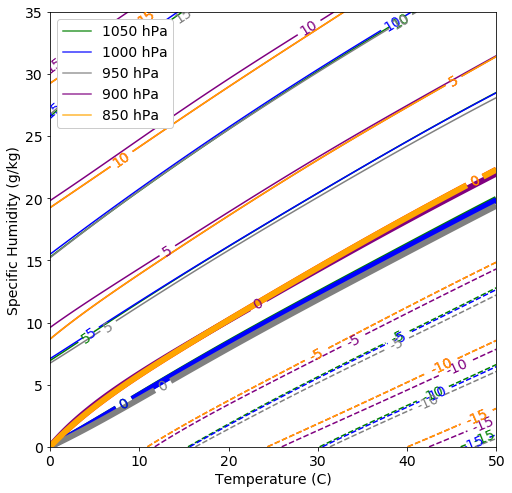

In [6]:
fig, axs = plt.subplots(1,figsize = (8,8))

cmaps = ['red','green','blue','grey', 'purple','orange']
labels = ['1050 hPa','1000 hPa','950 hPa','900 hPa','850 hPa','800 hPa']
levels = np.arange(-15,18,5)

for i in np.arange(np.shape(vs)[0]):
    v = vs[i]
    
    stick_TW = -1*(0 + v[1]*q_grid + v[2]*temp_grid + v[3]*q_grid*temp_grid + 
             v[4]*q_grid**2 + v[5]*temp_grid**2 + v[6]*(q_grid**2)*temp_grid + 
             v[7]*(temp_grid**2)*q_grid + v[8]*(q_grid**2)*(temp_grid**2) + 
             v[9]*q_grid**3 + v[10]*temp_grid**3 + v[11]*(q_grid**3)*temp_grid + 
             v[12]*(temp_grid**3)*q_grid + v[13]*(q_grid**3)*(temp_grid**2) + 
             v[14]*(temp_grid**3)*(q_grid**2) + v[15]*(q_grid**3)*(temp_grid**3))
    
    stick_cont = axs.contour(temp, 1000*q, stick_TW, colors=(cmaps[i],), levels = levels, alpha = 1)
    axs.clabel(stick_cont, inline=1, fontsize=14, fmt = '%1d')
    
    # Bold 0 contour
    ind = int(np.argwhere(stick_cont.levels == 0))
    stick_cont.collections[ind].set_linewidth(6)
    
line2 = Line2D([0], [0], color='green', alpha = 0.8, linestyle = 'solid')
line3 = Line2D([0], [0], color='blue', alpha = 0.8, linestyle = 'solid')
line4 = Line2D([0], [0], color='grey', alpha = 0.8, linestyle = 'solid')
line5 = Line2D([0], [0], color='purple', alpha = 0.8, linestyle = 'solid')
line6 = Line2D([0], [0], color='orange', alpha = 0.8, linestyle = 'solid')

axs.legend([line2,line3,line4,line5,line6],labels, loc = 'upper left', fontsize = 14, framealpha = 1)
axs.set_xlabel('Temperature (C)', fontsize = 14)
axs.set_ylabel('Specific Humidity (g/kg)', fontsize = 14)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

# Figure S3

In [10]:
# Find dewpoint range

# Generate temp range (in C)
N_steps = 500

min_temp = 25
max_temp = 50

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0
max_q = 0.02

q = np.linspace(min_q, max_q, N_steps)

pres = 1000*100 # set general surface pressure to 1000 hPa

# Calculate RH from T and q
RH = 0.263*(1000*100)*q*(np.exp((17.67*temp/(temp+273.15-29.65))))**(-1)

# Calculate dewpoint from RH and T
dewpoint = 243.04*(np.log(RH/100)+((17.625*temp)/(243.04+temp)))/(17.625-np.log(RH/100)-((17.625*temp)/(243.04+temp)))

# Create gridded arrays
temp_grid, dewpoint_grid = np.meshgrid(temp, dewpoint)
temp_grid, q_grid = np.meshgrid(temp, q)
pres_grid = np.ones_like(temp_grid)*pres

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'


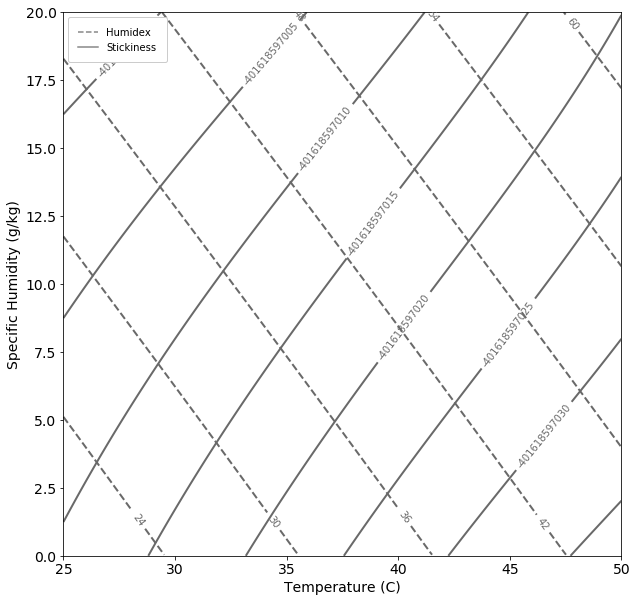

In [11]:
plt.rcParams.update({'font.size': 14})
    
result = [4.01618597e+11, -2.77446275e+01, -5.17161869e-01, -1.05894426e+01,
          -2.60701984e+01,  5.10029771e-02,  1.41873470e-01, -1.08316596e+00,
          3.06666755e-03,  9.85378201e-01, -5.19589656e-04,  1.41636661e-02,
          1.94092586e-02,  1.34532981e-04, -6.26289238e-05,  4.07757070e-07]

stick_humidex = -1*(result[0] + result[1]*q_grid + result[2]*temp_grid + result[3]*q_grid*temp_grid + 
             result[4]*q_grid**2 + result[5]*temp_grid**2 + result[6]*(q_grid**2)*temp_grid + 
             result[7]*(temp_grid**2)*q_grid + result[8]*(q_grid**2)*(temp_grid**2) + 
             result[9]*q_grid**3 + result[10]*temp_grid**3 + result[11]*(q_grid**3)*temp_grid + 
             result[12]*(temp_grid**3)*q_grid + result[13]*(q_grid**3)*(temp_grid**2) + 
             result[14]*(temp_grid**3)*(q_grid**2) + result[15]*(q_grid**3)*(temp_grid**3))

humidex = temp_grid + 0.5555*(6.11*np.exp(5417.7530*(1/273.16-1/(273.15+dewpoint_grid)))-10)

# Plot contours
label1 = ['Humidex']
plt.figure(figsize=(10,10))
humidex_cont = plt.contour(temp, 1000*q, humidex, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2, fontweight = 'bold', label = label1)
plt.clabel(humidex_cont, inline=1, fontsize=10, fmt = '%1d')

label2 = ['Stickiness']
stick_cont = plt.contour(temp, 1000*q, stick_humidex, colors=('dimgrey',),linestyles = 'solid', zorder = 2, linewidths = 2)
plt.clabel(stick_cont, inline=1, fontsize=10, fmt = '%1d')

plt.xlabel('Temperature (C)')
plt.ylabel('Specific Humidity (g/kg)')

line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
labels = ['Humidex', 'Stickiness']

plt.legend([line1, line2],labels, loc = 'upper left', framealpha=1, borderpad=1, fontsize = 10)

# Figure S4

In [30]:
# Generate temperature range (in degrees C)
N_steps = 500

min_temp = 15
max_temp = 50

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0
max_q = 0.035

q = np.linspace(min_q, max_q, N_steps)

# Calculate wet bulb temperature grid
pres = 1000*100 # set general surface pressure to 1000 hPa

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
pres_grid = np.ones_like(temp_grid)*pres

Cp = 1.005  # in units kJ/kg
Lv = 2260   #in units kJ/kg

MSE = Cp * temp_grid + Lv*q_grid

stick_analytic = Cp * temp_grid - Lv*q_grid;

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  


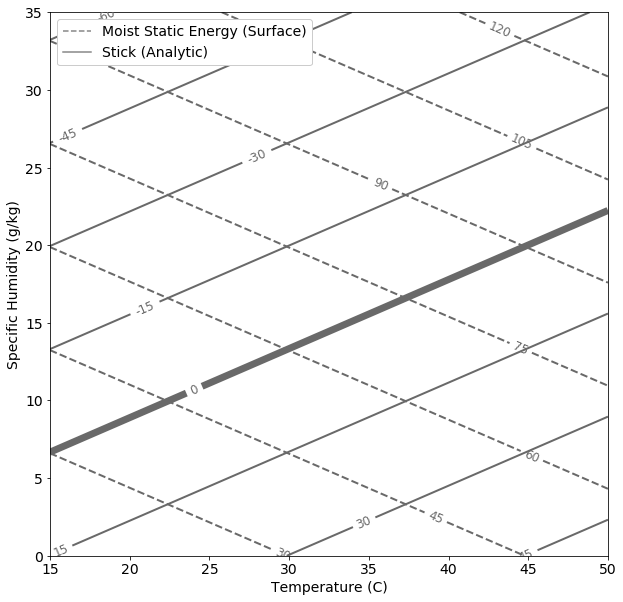

In [31]:
# Plot orthogonal contours
fig, axs = plt.subplots(1,1,figsize=(10,10))
MSE_cont = axs.contour(temp, 1000*q, MSE, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2, fontweight = 'bold', label = 'MSE')
axs.clabel(MSE_cont, inline=1, fontsize=12, fmt = '%1d')

stick_cont = axs.contour(temp, 1000*q, stick_analytic, colors=('dimgrey',),linestyles = 'solid', zorder = 2, linewidths = 2, fontweight = 'bold', label = 'Stick (Analytic)')
axs.clabel(stick_cont, inline=1, fontsize=12, fmt = '%1d')

axs.set_xlabel('Temperature (C)', fontsize = 14)
axs.set_ylabel('Specific Humidity (g/kg)', fontsize = 14)

line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
labels = ['Moist Static Energy (Surface)', 'Stick (Analytic)']

axs.legend([line1, line2],labels, loc = 'upper left', framealpha=1)

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

In [32]:
def stick_MSE(x):
    
    # Generate temperature range (in degrees C)
    N_steps = 500

    min_temp = 15
    max_temp = 50

    temp = np.linspace(min_temp,max_temp,N_steps)

    # Generate specific humidity range (in kg/kg)
    min_q = 0
    max_q = 0.035

    q = np.linspace(min_q, max_q, N_steps)
    
    # Calculate wet bulb temperature grid
    pres = 1000*100 # set general surface pressure to 1000 hPa

    # Make gridded arrays
    temp_grid, q_grid = np.meshgrid(temp, q) 
    pres_grid = np.ones_like(temp_grid)*pres
    
    Cp = 1.005  # in units kJ/kg
    Lv = 2260   #in units kJ/kg
    MSE = Cp * temp_grid + Lv*q_grid
    
    # Calculate stickiness using input vector
    C_10 = x[0]
    C_01 = x[1]
    
    spice = C_10*q_grid + C_01*temp_grid
    
    lam1 = 0.95
    lam2 = 1 - lam1
    
    dspice_dT, dspice_dq = np.gradient(spice)
    dMSE_dT, dMSE_dq = np.gradient(MSE)
    
    int1 = (dspice_dq / dMSE_dq + dspice_dT/dMSE_dT)**2
    int2 = (dspice_dq/dMSE_dq - 1)**2
    
    dq = (max_q - min_q)/N_steps
    dT = (max_temp - min_temp)/N_steps
    
    eps = (lam1*np.sum(int1)*dq*dT + lam2*np.sum(int2)*dq*dT)**0.5
    
    return eps

In [33]:
guess = np.array([500,100])
result = minimize(stick_MSE,guess, method='nelder-mead', options = {'xatol': 1e-12,'disp': True})
print('The final array that minimizes mean squared error is:'+ str(result.x))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 146
         Function evaluations: 285
The final array that minimizes mean squared error is:[-2.260e+03  1.005e+00]


In [34]:
result = [-2.260e+03, 1.005e+00]

In [35]:
# Check how good fit is
N_steps = 500

min_temp = 15
max_temp = 50

temp = np.linspace(min_temp,max_temp,N_steps)

# Generate specific humidity range (in kg/kg)
min_q = 0
max_q = 0.035

q = np.linspace(min_q, max_q, N_steps)
    
# Calculate MSE grid
pres = 1000*100 # set general surface pressure to 1000 hPa

# Make gridded arrays
temp_grid, q_grid = np.meshgrid(temp, q) 
pres_grid = np.ones_like(temp_grid)*pres

Cp = 1.005 + 1.82*q_grid # in units kT/kgC
Lv = 2500.8 - 2.36 * temp_grid + 0.0016 * temp_grid**2 - 0.00006 * temp_grid**3
MSE = Cp * temp_grid + Lv*q_grid
    
# Calculate stickiness using input vector
C_01 = Cp
C_10 = - Lv
    
spice = C_01*temp_grid + C_10*q_grid
    
dspice_dT, dspice_dq = np.gradient(spice)
dMSE_dT, dMSE_dq = np.gradient(MSE)
    
int1 = (dspice_dq / dMSE_dq + dspice_dT/dMSE_dT)**2
int2 = (dspice_dq/dMSE_dq - 1)**2

dq = (max_q - min_q)/N_steps
dT = (max_temp - min_temp)/N_steps

lam1 = 0.95
lam2 = 1 - lam1
    
eps = lam1*np.sum(int1)*dq*dT + lam2*np.sum(int2)*dq*dT

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'fontweight', 'label'
  # Remove the CWD from sys.path while we load stuff.
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  


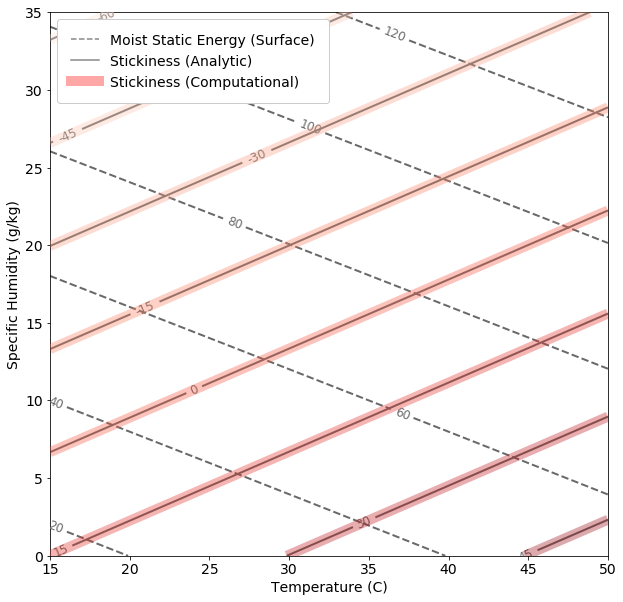

In [36]:
stick_comp = result[1]*temp_grid + result[0]*q_grid;

# Plot contours
fig, axs = plt.subplots(1,1,figsize=(10,10))
MSE_cont = axs.contour(temp, 1000*q, MSE, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2, fontweight = 'bold', label = 'MSE')
axs.clabel(MSE_cont, inline=1, fontsize=12, fmt = '%1d')

# Analytic
stick_cont_anal = axs.contour(temp, 1000*q, stick_analytic, colors=('dimgrey',),linestyles = 'solid', zorder = 2, linewidths = 2, fontweight = 'bold', label = 'Stick (Analytic)')
axs.clabel(stick_cont_anal, inline=1, fontsize=12, fmt = '%1d')

# Computational
stick_cont_comp = plt.contour(temp, 1000*q, stick_comp, cmap = 'Reds', label = 'Stick (Comp.)', linewidths = 10, alpha = 0.35, zorder = 5)

axs.set_xlabel('Temperature (C)', fontsize = 14)
axs.set_ylabel('Specific Humidity (g/kg)', fontsize = 14)

line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
line3 = Line2D([0], [0], color='red', alpha = 0.35, linestyle = 'solid', linewidth = 10)
labels = ['Moist Static Energy (Surface)', 'Stickiness (Analytic)', 'Stickiness (Computational)']

axs.legend([line1, line2,line3],labels, loc = 'upper left', framealpha=1, borderpad=1)

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(14)

# Figure S20

In [3]:
# Load full datasets
TW_allstations2 = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_TW_allstations.csv", sep='\t')
Tmax_allstations2 = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_Tmax_allstations.csv", sep='\t')
simulT_allstations2 = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulT_allstations.csv", sep='\t')
simulSH_allstations2 = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulSH_allstations.csv", sep='\t')

print('All data has been loaded.')

All data has been loaded.


In [4]:
col_names = ['stncodes','stnlats','stnlons','stnelevs']
stndata = pd.read_csv('/home/ivanov/matlab/Code/MJO_TW/hadisd_station_metadata_v2019.txt', delimiter = '\s+', header = None, names = col_names)

# Get individual pieces of station data
stncodes = stndata.stncodes.values
stnlats = stndata.stnlats.values
stnlons = stndata.stnlons.values
stnelevs = stndata.stnelevs.values

In [5]:
TW_allstations2['month'] = pd.to_datetime(TW_allstations2.Date).dt.month
simulT_allstations2['month'] = pd.to_datetime(simulT_allstations2.Date).dt.month
simulSH_allstations2['month'] = pd.to_datetime(simulSH_allstations2.Date).dt.month

TW_allstations_JJA = TW_allstations2.loc[TW_allstations2.month.isin([6,7,8])]
simulT_allstations_JJA = simulT_allstations2.loc[simulT_allstations2.month.isin([6,7,8])]
simulSH_allstations_JJA = simulSH_allstations2.loc[simulSH_allstations2.month.isin([6,7,8])]

TW_allstations_JJA = TW_allstations_JJA.drop(columns = ['Unnamed: 0','Date','month'])
simulT_allstations_JJA = simulT_allstations_JJA.drop(columns = ['Unnamed: 0','Date','month'])
simulSH_allstations_JJA = simulSH_allstations_JJA.drop(columns = ['Unnamed: 0','Date','month'])

In [6]:
# Find stations within each region of analysis

europe_idx = np.where((stnlons > 2.5) & (stnlons < 21) & (stnlats >48) & (stnlats < 55))
SEasia_idx = np.where((stnlons > 103) & (stnlons < 110) & (stnlats >22) & (stnlats < 29))
alaska_idx = np.where((stnlons > -167) & (stnlons < -148) & (stnlats >59) & (stnlats < 71))

europe_stns = list(stncodes[europe_idx])
SEasia_stns = list(stncodes[SEasia_idx])
alaska_stns = list(stncodes[alaska_idx])

# Temperature
europe_simulT = simulT_allstations_JJA[simulT_allstations_JJA.columns[simulT_allstations_JJA.columns.isin(europe_stns)]]
SEasia_simulT = simulT_allstations_JJA[simulT_allstations_JJA.columns[simulT_allstations_JJA.columns.isin(SEasia_stns)]]
alaska_simulT = simulT_allstations_JJA[simulT_allstations_JJA.columns[simulT_allstations_JJA.columns.isin(alaska_stns)]]

europe_T = []

for column in europe_simulT.columns.values:
    to_add = europe_simulT[column].values
    europe_T.extend(to_add)
    
SEasia_T = []

for column in SEasia_simulT.columns.values:
    to_add = SEasia_simulT[column].values
    SEasia_T.extend(to_add)
    
alaska_T = []

for column in alaska_simulT.columns.values:
    to_add = alaska_simulT[column].values
    alaska_T.extend(to_add)

europe_simulT_mean = np.nanmean(europe_T)
SEasia_simulT_mean = np.nanmean(SEasia_T)
alaska_simulT_mean = np.nanmean(alaska_T)

# Specific Humidity
europe_simulSH = simulSH_allstations_JJA[simulSH_allstations_JJA.columns[simulSH_allstations_JJA.columns.isin(europe_stns)]]
SEasia_simulSH = simulSH_allstations_JJA[simulSH_allstations_JJA.columns[simulSH_allstations_JJA.columns.isin(SEasia_stns)]]
alaska_simulSH = simulSH_allstations_JJA[simulSH_allstations_JJA.columns[simulSH_allstations_JJA.columns.isin(alaska_stns)]]

europe_SH = []

for column in europe_simulSH.columns.values:
    to_add = europe_simulSH[column].values
    europe_SH.extend(to_add)
    
SEasia_SH = []

for column in SEasia_simulSH.columns.values:
    to_add = SEasia_simulSH[column].values
    SEasia_SH.extend(to_add)
    
alaska_SH = []

for column in alaska_simulSH.columns.values:
    to_add = alaska_simulSH[column].values
    alaska_SH.extend(to_add)

europe_simulSH_mean = np.nanmean(europe_SH)
SEasia_simulSH_mean = np.nanmean(SEasia_SH)
alaska_simulSH_mean = np.nanmean(alaska_SH)

# Tw
europe_TW_df = TW_allstations_JJA[TW_allstations_JJA.columns[TW_allstations_JJA.columns.isin(europe_stns)]]
europe_TW = []

for column in europe_TW_df.columns.values:
    to_add = europe_TW_df[column].values
    europe_TW.extend(to_add)
    
europe_99th = np.nanpercentile(europe_TW, 99)
europe_99th_idx = np.where((europe_TW > europe_99th))

SEasia_TW_df = TW_allstations_JJA[TW_allstations_JJA.columns[TW_allstations_JJA.columns.isin(SEasia_stns)]]
SEasia_TW = []

for column in SEasia_TW_df.columns.values:
    to_add = SEasia_TW_df[column].values
    SEasia_TW.extend(to_add)
    
SEasia_99th = np.nanpercentile(SEasia_TW, 99)
SEasia_99th_idx = np.where((SEasia_TW > SEasia_99th))

alaska_TW_df = TW_allstations_JJA[TW_allstations_JJA.columns[TW_allstations_JJA.columns.isin(alaska_stns)]]
alaska_TW = []

for column in alaska_TW_df.columns.values:
    to_add = alaska_TW_df[column].values
    alaska_TW.extend(to_add)
    
alaska_99th = np.nanpercentile(alaska_TW, 99)
alaska_99th_idx = np.where((alaska_TW > alaska_99th))

europe_simulT_ext = np.nanmean(np.array(europe_T)[np.squeeze(europe_99th_idx)])
SEasia_simulT_ext = np.nanmean(np.array(SEasia_T)[np.squeeze(SEasia_99th_idx)])
alaska_simulT_ext = np.nanmean(np.array(alaska_T)[np.squeeze(alaska_99th_idx)])

europe_simulSH_ext = np.nanmean(np.array(europe_SH)[np.squeeze(europe_99th_idx)])
SEasia_simulSH_ext = np.nanmean(np.array(SEasia_SH)[np.squeeze(SEasia_99th_idx)])
alaska_simulSH_ext = np.nanmean(np.array(alaska_SH)[np.squeeze(alaska_99th_idx)])

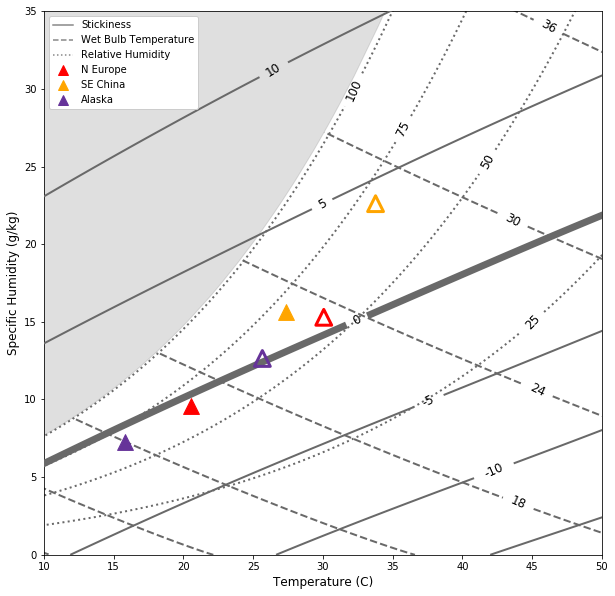

In [13]:
result = [1.199557787089589, -7.75269363e+02, 3.02416275e-01, 3.08627625e+00,
              7.74095672e+03, 1.78241619e-03, -2.38012318e+02, -4.98714576e-01,
              2.40170949e+01, 7.18600120e+03, -2.75682633e-05, 4.29814844e+02,
              7.01883383e-03, -2.83672170e+02, -3.67109506e-01, 5.09430371e+00]

stick_TW = -1*(result[0] + result[1]*q_grid + result[2]*temp_grid + result[3]*q_grid*temp_grid + 
             result[4]*q_grid**2 + result[5]*temp_grid**2 + result[6]*(q_grid**2)*temp_grid + 
             result[7]*(temp_grid**2)*q_grid + result[8]*(q_grid**2)*(temp_grid**2) + 
             result[9]*q_grid**3 + result[10]*temp_grid**3 + result[11]*(q_grid**3)*temp_grid + 
             result[12]*(temp_grid**3)*q_grid + result[13]*(q_grid**3)*(temp_grid**2) + 
             result[14]*(temp_grid**3)*(q_grid**2) + result[15]*(q_grid**3)*(temp_grid**3))

# Plot contours
label1 = ['Wet Bulb']
plt.figure(figsize=(10,10))
manual_TW = [(45, 5), (45, 10), (42.5, 20), (45, 32.5)]
TW_cont = plt.contour(temp, 1000*q, Twb, colors=('dimgrey',), linestyles = 'dashed', zorder = 1, linewidths = 2)
TW_clabels = plt.clabel(TW_cont, inline=1, fontsize=12, fmt = '%1d',manual=manual_TW, colors = 'k')

label2 = ['Stickiness (Comp.)']
manual_stick = [(42.5, 5), (37.5, 10), (32.5, 15), (30, 22.5), (27.5,30)]
stick_cont = plt.contour(temp, 1000*q, stick_TW, colors=('dimgrey',),linestyles = 'solid', vmin = -20, vmax = 20, zorder = 4, linewidths = 2)
stick_clabels = plt.clabel(stick_cont, inline=1, fontsize=12, fmt = '%1d',manual=manual_stick, colors = 'k')

# Plot lines of constant RH
label3 = ['Relative Humidity']
levels = [25,50,75,100]
manual_RH = [(45, 15), (42.5, 25), (37, 27), (32, 30)]
RH_cont = plt.contour(temp_grid, 1000*q_grid, RH_grid, colors = ('dimgrey',), linestyles = 'dotted', levels = levels, linewidths = 2, zorder = 2)
RH_clabels = plt.clabel(RH_cont, inline = 1, fontsize=12, fmt = '%1d',manual=manual_RH, colors = 'k')

# Bold 0 contour
ind = int(np.argwhere(stick_cont.levels == 0))
stick_cont.collections[ind].set_linewidth(7)

# Add scatters for each station location
europe_mean = plt.scatter(europe_simulT_mean, 1000*europe_simulSH_mean, s = 250, color = 'r', marker = '^', zorder = 5)
europe_extr = plt.scatter(europe_simulT_ext, 1000*europe_simulSH_ext, s = 250, edgecolor = 'r', facecolor = 'none',marker = '^', linewidths = 3,zorder = 5)

SEasia_mean = plt.scatter(SEasia_simulT_mean, 1000*SEasia_simulSH_mean, s = 250, color = 'orange', marker = '^', zorder = 5)
SEasia_extr = plt.scatter(SEasia_simulT_ext, 1000*SEasia_simulSH_ext, s = 250, edgecolor = 'orange', facecolor = 'none',marker = '^', linewidths = 3,zorder = 5)

alaska_mean = plt.scatter(alaska_simulT_mean, 1000*alaska_simulSH_mean, s = 250, color = 'rebeccapurple', marker = '^', zorder = 5)
alaska_extr = plt.scatter(alaska_simulT_ext, 1000*alaska_simulSH_ext, s = 250, edgecolor = 'rebeccapurple', facecolor = 'none',marker = '^', linewidths = 3,zorder = 5)

plt.xlabel('Temperature (C)', fontsize = 12)
plt.ylabel('Specific Humidity (g/kg)', fontsize = 12)
plt.xlim([10,50])
plt.ylim([0,35])

# Shading for supersaturated regions
shading = plt.fill_between(data_CC_SD['Wet Bulb'], 1000*data_CC_SD['Specific Humidity'], 100, color='white', alpha=1, zorder = 1)
shading = plt.fill_between(data_CC_SD['Wet Bulb'], 1000*data_CC_SD['Specific Humidity'], 100, color='grey', alpha=.25, zorder = 2)

line2 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dashed')
line1 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'solid')
line3 = Line2D([0], [0], color='dimgrey', alpha = 0.8, linestyle = 'dotted')

triangle1 = Line2D([], [], color='r', marker='^', linestyle='None',
                          markersize=10)
triangle2 = Line2D([], [], color='orange', marker='^', linestyle='None',
                          markersize=10)
triangle3 = Line2D([], [], color='rebeccapurple', marker='^', linestyle='None',
                          markersize=10)

labels = ['Stickiness','Wet Bulb Temperature', 'Relative Humidity','N Europe','SE China', 'Alaska']

plt.legend([line1, line2,line3,triangle1,triangle2,triangle3], labels, loc = 'upper left', framealpha=1)